# **SHAKESPEARE'S SONNETS**

## Problem
Learn from [Shakespeare's sonnets]() (cleaned) to auto-generate poems.

## Initialize

In [1]:
import os
import io
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import regularizers

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

**Global inputs**

In [3]:
PAD_TYPE = 'pre'
LOG_DIR = '03-logs'
PROBLEM = 'poem'
EMBED_DIMS = 100

## Dataset
**Get the dataset**

In [4]:
data_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt'
path_out = '../.tmp/sonnets.txt'

# download the dataset
if not os.path.exists(path_out):
    os.system(f"""wget --no-check-certificate {data_url} -O {path_out}""")

# read the text file
with open(path_out, 'r') as f:
    data = f.read().split('\n')

# check the data
data[:5]

['FROM fairest creatures we desire increase,',
 "That thereby beauty's rose might never die,",
 'But as the riper should by time decease,',
 'His tender heir might bear his memory:',
 'But thou, contracted to thine own bright eyes,']

## Pre-processing

In [5]:
# convert all texts to lower case
corpus = [line.lower() for line in data]

# initiate a tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
# update the vocabulary on the texts
tokenizer.fit_on_texts(corpus)

# total number of words
total_words = len(tokenizer.word_index) + 1

# create input sequences
input_sequences = []
max_len = 0
for line in corpus:
    # ignore empty lines
    if line == '':
        continue
    # convert the text line to a list of tokens
    token_line = tokenizer.texts_to_sequences([line])[0]
    # create sequence of 1st 2, 3, ... words (a.k.a. n-gram sequence)
    for i in range(1, len(token_line)):
        n_gram_sequence = token_line[:i+1]
        # append to the input sequences
        input_sequences.append(n_gram_sequence)
        # keep track of maximum length
        max_len = max(max_len, len(n_gram_sequence))

# padded sequences
input_sequences = pad_sequences(input_sequences, padding=PAD_TYPE, maxlen=max_len)
# convert to numpy array
input_sequences = np.array(input_sequences)

# the sequence up to 2nd to the last is predictor
predictors = input_sequences[:, :-1]
# the last one in the sequence is the label
labels = input_sequences[:, -1]
# convert labels to one-hot encodings
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
# check
print(f'data size: {input_sequences.shape}')
for i in range(5):
    print(f'predictor: {predictors[i]}, label: {labels[i]}')

data size: (15462, 11)
predictor: [ 0  0  0  0  0  0  0  0  0 35], label: [0. 0. 0. ... 0. 0. 0.]
predictor: [  0   0   0   0   0   0   0   0  35 418], label: [0. 0. 0. ... 0. 0. 0.]
predictor: [  0   0   0   0   0   0   0  35 418 878], label: [0. 0. 0. ... 0. 0. 0.]
predictor: [  0   0   0   0   0   0  35 418 878 167], label: [0. 0. 0. ... 0. 0. 0.]
predictor: [  0   0   0   0   0  35 418 878 167 214], label: [0. 0. 0. ... 0. 0. 0.]


## Pre-trained Embeddings

**GloVe**
([See more](https://nlp.stanford.edu/projects/glove/))


In [7]:
data_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt'
path_out = '../.tmp/glove.6B.100d.txt'
save_mat = LOG_DIR + '/' + PROBLEM + '-glove_embedding.npy'

# download the dataset
if not os.path.exists(path_out):
    os.system(f"""wget --no-check-certificate {data_url} -O {path_out}""")

if os.path.exists(save_mat):
    embeddings_matrix = np.load(save_mat)
else:
    embeddings_index = {}
    with open(path_out, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embeddings_matrix = np.zeros((total_words, EMBED_DIMS))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    np.save(save_mat, embeddings_matrix)

# pre-trained embeddings
print(embeddings_matrix.shape)

(3212, 100)


## Model

**Note**
- We used a pre-trained embedding layers (kept the layer frozen).
- Then, a bidirectional LSTM layer.
- Before the output layer, we used a dense layer with kernel regulizer.
- We used `'softmax'` activation function in output layer since it is a multi-class classification problem.
- Since the multi-class labels are one-hot encoded, we used `'categorical_crossentropy'` as loss function.

In [8]:
# input layer
input_tensor = Input(shape=max_len-1)  # -1 because we used one for label

# pre-trained embedding layer
x = Embedding(
    input_dim=embeddings_matrix.shape[0],
    output_dim=embeddings_matrix.shape[1],
    input_length=max_len-1,  # -1 because we used one for label
    weights=[embeddings_matrix],
    trainable=False
)(input_tensor)

# hidden layers
x = Bidirectional(LSTM(150, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = LSTM(100)(x)
x = Dense(total_words//2, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

# output layer
output_tensor = Dense(total_words, activation='softmax')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy'
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 100)           321200    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1606)              162206    
_________________________________________________________________
dense_1 (Dense)              (None, 3212)              516168

## Train

**Callbacks**

In [9]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='loss', mode='min', factor=0.1, patience=5, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='loss',  mode='min', min_delta=0, patience=20, verbose=2, restore_best_weights=True
)

**Start Training**

In [10]:
# train the model
hist = model.fit(
    predictors, labels,
    epochs=100,
    verbose=1,
    callbacks=[reduce_rl, early_stopping]
)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 10s 624us/sample - loss: 6.9036 - los
Epoch 2/100
15462/15462 [==============================] - 5s 339us/sample - loss: 6.5539
Epoch 3/100
15462/15462 [==============================] - 5s 331us/sample - loss: 6.5006
Epoch 4/100
15462/15462 [==============================] - 5s 333us/sample - loss: 6.4584
Epoch 5/100
15462/15462 [==============================] - 5s 333us/sample - loss: 6.3882s - loss: 6 - ETA:
Epoch 6/100
15462/15462 [==============================] - 5s 336us/sample - loss: 6.3123s - loss: 6.314
Epoch 7/100
15462/15462 [==============================] - 5s 334us/sample - loss: 6.2389
Epoch 8/100
15462/15462 [==============================] - 5s 340us/sample - loss: 6.1585
Epoch 9/100
15462/15462 [==============================] - 5s 327us/sample - loss: 6.0835s - loss:  
Epoch 10/100
15462/15462 [==============================] - 5s 329us/sample - loss: 6.0050
Epoch 11/100
15462/15462 

15462/15462 [==============================] - 5s 355us/sample - loss: 1.5981
Epoch 90/100
15462/15462 [==============================] - 5s 351us/sample - loss: 1.5635
Epoch 91/100
15462/15462 [==============================] - 6s 356us/sample - loss: 1.5602
Epoch 92/100
15462/15462 [==============================] - 5s 353us/sample - loss: 1.5618
Epoch 93/100
15462/15462 [==============================] - 5s 354us/sample - loss: 1.5344
Epoch 94/100
15462/15462 [==============================] - 6s 361us/sample - loss: 1.5263
Epoch 95/100
15462/15462 [==============================] - 6s 361us/sample - loss: 1.5045
Epoch 96/100
15462/15462 [==============================] - 5s 352us/sample - loss: 1.4968
Epoch 97/100
15462/15462 [==============================] - 6s 359us/sample - loss: 1.4728
Epoch 98/100
15462/15462 [==============================] - 6s 361us/sample - loss: 1.4665
Epoch 99/100
15462/15462 [==============================] - 6s 360us/sample - loss: 1.4452
Epoch 100/10

**Show training graphs**

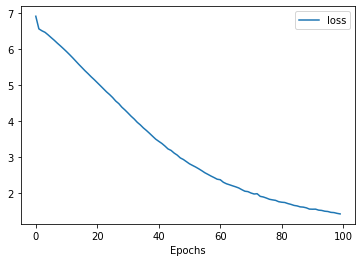

In [11]:
def plot_graphs(history, metrics):
    plt.figure()
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

plot_graphs(hist, ["loss"])

## Auto-generate Poems

In [12]:
seed_text = "I look into your eyes, and I can see"
next_words = 100

# index to word dictionary
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

for _ in range(next_words):
    # generate sequence
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # padding
    token_list = pad_sequences([token_list], maxlen=max_len-1, padding=PAD_TYPE)
    # predict the next word
    predicted = model.predict(token_list)
    predicted = int(np.argmax(predicted, axis=1).squeeze())
    # index to word
    output_word = reverse_word_index[predicted]
    # add to the seed text
    seed_text += " " + output_word

print(seed_text)

I look into your eyes, and I can see down from clouds for love's well might one brain and skill can sit more none so much my dear friend ' grow part light rage are bide dead far new woe new day be allay'd kind ill grow still so grow than ill now made too near of care or kind needing friend ' so 'will gone new one erred hid do behold grow bright days bright cold new fired night had cold did hush the wind come crown'd the pebbled night as men had hush on every truth on to you deem'd sit tell now he forgot be grow
